<code>plot_RMSE_VRILE_error_propagation.ipynb</code> plots RMSE after VRILE events to track error propagation

In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from S2S_sea_ice_plotting import RMSE_plot_error

### Inputs:
* <code>model_names</code>: which models to include (helpful for debugging)
* <code>seas_str</code>: which season to plot (string) (for this notebook, we'll just do ALL)
* <code>seas_sel</code>: months to include (array) (all months for this notebook)
* <code>vrile_thresh</code>: threshold for VRILE calculation (string)
* <code>clim_freq</code>: lead time in days or weeks (string)
* <code>TO_PLOT</code>: are we plotting SIE or SIE anom?
* <code>obs_name</code>: which set of obs to use (string)
* <code>obs_name_plt</code>: name of obs (for plot, string)
* <code>VRILE_shift</code>: int, how many days before the VRILE do we start forecasting}

In [2]:
ALL_REGIONS = False 
model_names = ['ecmwf','ukmo','metreofr','ncep','DAMPED_ANOMALY']
#model_names = ['DAMPED_ANOMALY']
seas_str_ALL = ['JJA','JFM']
#seas_str = 'JJA'
seas_sel = [1,2,3,4,5,6,7,8,9,10,11,12]
vrile_thresh = '05'
clim_freq = 'WEEKLY'
TO_PLOT = 'SIE anom RMSE'
obs_name = 'NSIDC_0079'
obs_name_plt = 'NASA Bootstrap'
VRILE_shift = 21

### Steps
1. Load on RMSE spreadsheets for all days and VRILE days, and combine all models into one spreadsheet 
2. Plot RMSE vs lead time for specified season for desired regions. 

In [3]:
d_SIE_all = pd.DataFrame()
fpath_load = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/data/'
for seas_str in seas_str_ALL:
    for i_model in model_names:
        # Damped anomaly has different filename
        if i_model == 'DAMPED_ANOMALY':
            fpath_all = fpath_load+'{model_name}_{obs_name}/OBS_{obs_name}/'.format(model_name=i_model,obs_name=obs_name)       
            fpath_all = fpath_all+'COMMON_RF/ERROR_PROP_{VRILE_shift}day_shift_VRILE_vs_NOVRILE_RMSE_MAE_{model_name}_{obs_name}_months{seas_str}_VRILE{vrile_thresh}_model_clim_freq_{clim_freq}.csv'.format(VRILE_shift=VRILE_shift,model_name=i_model,
                                                                                    obs_name=obs_name,seas_str=seas_str,
                                                                                                vrile_thresh=vrile_thresh,
                                                                                                clim_freq=clim_freq)
            d_SIE = pd.read_csv(fpath_all)
            d_SIE['Model Name'] = obs_name_plt
            d_SIE['Season'] = seas_str
            d_SIE_all = d_SIE_all.append(d_SIE)

        else:
            # Load ALL DAYS
            fpath_all = fpath_load+'{model_name}/OBS_{obs_name}/COMMON_RF/ERROR_PROP_{VRILE_shift}day_shift_VRILE_vs_NOVRILE_RMSE_MAE_{model_name}_months{seas_str}_VRILE{vrile_thresh}_model_clim_freq_{clim_freq}.csv'.format(model_name=i_model,
                                                                                                    obs_name=obs_name,VRILE_shift=VRILE_shift,
                                                                                                    seas_str=seas_str,
                                                                                                    vrile_thresh=vrile_thresh,
                                                                                                    clim_freq=clim_freq)
            d_SIE = pd.read_csv(fpath_all)
            # Because we spelled "meteofr" wrong
            if i_model == 'metreofr':
                d_SIE['Model Name'] = 'meteofr'
            else:
                d_SIE['Model Name'] = i_model
            # 
            d_SIE['Season'] = seas_str
            d_SIE_all = d_SIE_all.append(d_SIE)



Mask days and regions with p-value less than 1.96

In [4]:
pval_thresh = 1.96
d_SIE_all_mask = d_SIE_all.mask(abs(d_SIE_all['p-value'])<pval_thresh)
SIE_df_RMSE_all = d_SIE_all.groupby(['Season','Model Name',
                                     'region','type','lead days'])['SIE RMSE','SIE MAE','SIE anom RMSE','SIE anom MAE'].mean()
SIE_df_pmask_count = d_SIE_all_mask.groupby(['Season','Model Name','region','type','lead days'])['p-value','sample size'].count()
SIE_df_pmask_RMSE = d_SIE_all_mask.groupby(['Season','Model Name','region',
                                            'type','lead days'])['SIE RMSE','SIE MAE','SIE anom RMSE','SIE anom MAE','p-value'].mean()

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


Now, based on our binomial distribution, we have determined that we need at least 13 of 16 folds to be significant for the RMSE on that lead day / region / model combination to be significant at 95% (that is, we need RMSE on VRILE days vs non-VRILE days to be significantly different for at least 13 of 16 folds for us to be able to reject the null hypothesis--that VRILE days are not significantly different from non-VRILE days).

At 90% we need 12 folds to be significant.

In [5]:
alpha_sel = 0.05
if alpha_sel == 0.05:
    fold_no = 13
elif alpha_sel == 0.1:
    fold_no = 12
else:
    for i_a in np.arange(16,0,-1):
        print(i_a)
        a_max = scipy.stats.binom_test(i_a,16, p=0.5, alternative='two-sided')
        if ((a_max > alpha) == True):
            print('use ',i_a+1,' folds')
            fold_no = i_a+1
            break
SIE_df_mask_folds = SIE_df_pmask_RMSE.mask(SIE_df_pmask_count['p-value'] < fold_no)

Shorten region names and replace to plot in desired order

In [6]:
data_FULL = SIE_df_RMSE_all.reset_index()
data_SIG_ONLY = SIE_df_mask_folds.reset_index()


In [7]:
regions_sort = ["panArctic","Central Arctic","E. Sib./Beauf./Chuk. Sea","Kara-Laptev Sea","Barents Sea",
               "E. Greenland Sea","Bering"]
data_FULL['region'] = data_FULL['region'].replace({'East Greenland Sea':'E. Greenland Sea',
    'East Siberian-Beaufort-Chukchi Sea':'E. Sib./Beauf./Chuk. Sea'})
data_SIG_ONLY['region'] = data_SIG_ONLY['region'].replace({'East Greenland Sea':'E. Greenland Sea',
    'East Siberian-Beaufort-Chukchi Sea':'E. Sib./Beauf./Chuk. Sea'})
##
data_FULL['region sort'] = pd.Categorical(data_FULL['region'],regions_sort)
data_SIG_ONLY['region sort'] = pd.Categorical(data_SIG_ONLY['region'],regions_sort)
##
#d_SIE_DA['region'] = d_SIE_DA['region'].replace({'East Greenland Sea':'E. Greenland Sea',
#    'East Siberian-Beaufort-Chukchi Sea':'E. Sib./Beauf./Chuk. Sea'})
#d_SIE_DA['region sort'] = pd.Categorical(d_SIE_DA['region'],regions_sort)

Fix model names so they are capitalized

In [8]:
data_FULL['Model Name'] = data_FULL['Model Name'].replace({'ecmwf':'ECMWF','ukmo':'UKMO','ncep':'NCEP',
                                                          'meteofr':'METEOFR'})
data_SIG_ONLY['Model Name'] = data_SIG_ONLY['Model Name'].replace({'ecmwf':'ECMWF','ukmo':'UKMO','ncep':'NCEP',
                                                          'meteofr':'METEOFR'})

In [9]:
models_sort = ["ECMWF","METEOFR","NCEP","UKMO","NASA Bootstrap"]
data_FULL['Model'] = pd.Categorical(data_FULL['Model Name'],models_sort)
data_SIG_ONLY['Model'] = pd.Categorical(data_SIG_ONLY['Model Name'],models_sort)

Group by region, season, model name, lead time, and type (VRILE or nonVRILE day)

In [10]:
d_SIE_all_gb = data_FULL.groupby(['region sort','Season','Model','type','lead days']).mean()
data_SIG_ONLY_gb = data_SIG_ONLY.groupby(['region sort','Season','Model','type','lead days']).mean()

Plot

/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/figures/error_prop/ERROR_PROP_21day_shift_JJA_JFM_ex_regions.pdf


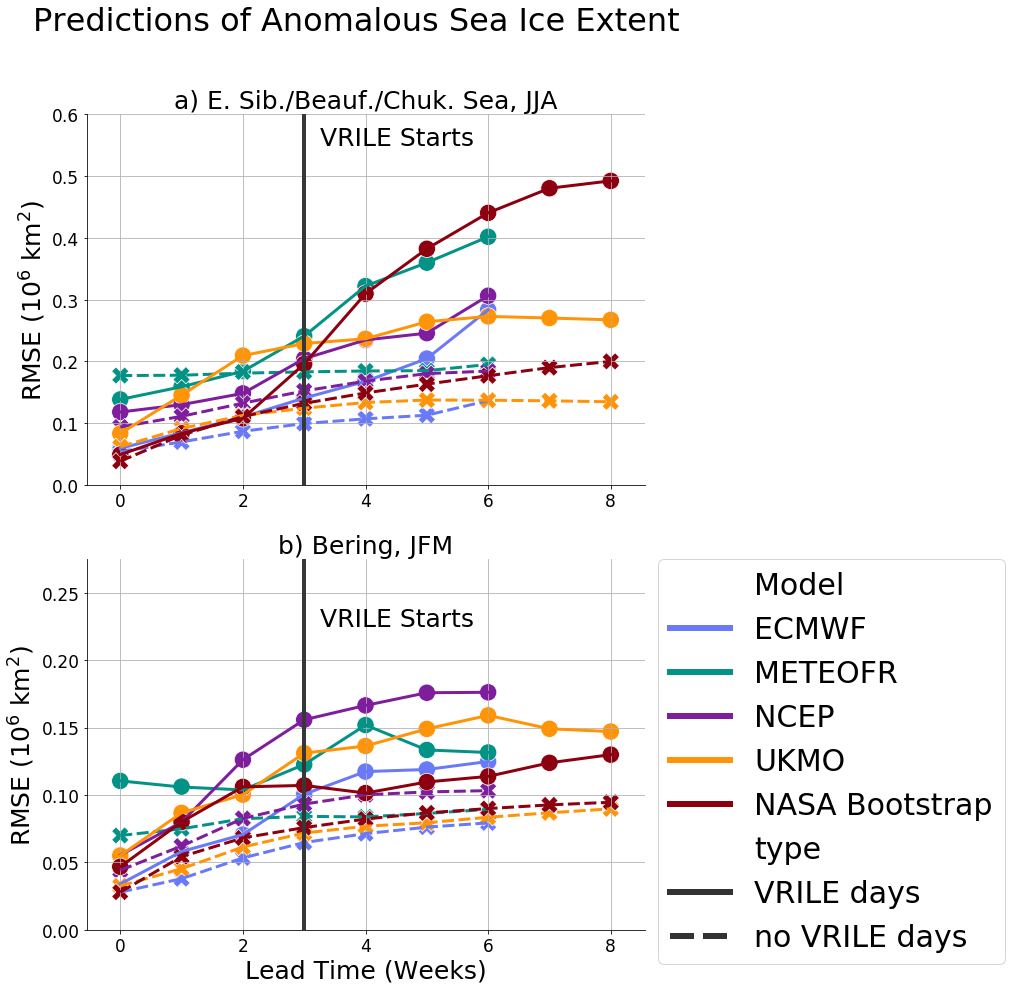

In [13]:
reg_plt = ['E. Sib./Beauf./Chuk. Sea','Bering']
vmax = [0.6,0.275]
no_regions = len(reg_plt)
fig1,ax1 = plt.subplots(2,1,figsize=(10,15))
ncols = 1
nrows = 2
for i in np.arange(0,no_regions):
    ax_sel = ax1.flat[i]
    reg_sel = reg_plt[i]
    if (reg_sel == 'Bering') | (reg_sel == 'E. Greenland Sea'):
        seas_sel = 'JFM'
    else:
        seas_sel = seas_str_ALL[0]
    data_plt = d_SIE_all_gb.xs((reg_sel,seas_sel)).reset_index()
    data_scatter = data_SIG_ONLY_gb.xs((reg_sel,seas_sel)).reset_index()
    v_min = 0
    v_max = vmax[i]
    RMSE_plot_error(ax_sel,data_plt,data_scatter,reg_sel,TO_PLOT,i,v_min,v_max,VRILE_shift,clim_freq,
                    seas_sel,no_regions,ncols,nrows)
    
if TO_PLOT == 'SIE RMSE':
    fig1.suptitle('Predictions of Sea Ice Extent',fontsize=32,y=0.98)
else:
    fig1.suptitle('Predictions of Anomalous Sea Ice Extent',fontsize=32,y=0.98)
#fig1.text(0.275,0.9,'All Year',fontsize=28)
#fig1.text(0.7,0.9,'{seas_str} Only'.format(seas_str=seas_str2),fontsize=28)
fdir_save = "/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/figures/error_prop/"
if not os.path.exists(fdir_save):
    os.mkdir(fdir_save)
fname_save = fdir_save+'ERROR_PROP_{VRILE_shift}day_shift_{seas_str1}_{seas_str2}_ex_regions.pdf'.format(VRILE_shift=VRILE_shift,
                                                                seas_str1=seas_str_ALL[0],seas_str2=seas_str_ALL[1])
fig1.savefig(fname_save,format='pdf',bbox_inches='tight')
print(fname_save)

In [12]:
d_SIE_all_gb.xs(('panArctic','JFM','NASA Bootstrap')).reset_index()


,type,lead days,SIE RMSE,SIE MAE,SIE anom RMSE,SIE anom MAE
0,VRILE days,0.0,0.094387,0.073463,0.091592,0.068554
1,VRILE days,1.0,0.134339,0.111533,0.139939,0.116998
2,VRILE days,2.0,0.144092,0.115202,0.157702,0.131468
3,VRILE days,3.0,0.162052,0.129003,0.173712,0.138577
4,VRILE days,4.0,0.171098,0.133314,0.202925,0.157166
5,VRILE days,5.0,0.200339,0.151847,0.231330,0.168143
6,VRILE days,6.0,0.226169,0.176731,0.226275,0.163605
7,VRILE days,7.0,0.234499,0.188336,0.223729,0.171126
8,VRILE days,8.0,0.243723,0.201301,0.223662,0.178289
9,no VRILE days,0.0,0.081896,0.062860,0.081680,0.062725
